<a href="https://colab.research.google.com/github/XinXu-ease/XAI-assignment3-9.28/blob/main/XAI_assignment_9_29_Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/housing.csv")
print("First 5 records:", df.head())


Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices
First 5 records:    longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

In [4]:
#Data Structure
print("Data Structure")
print(f"Dimentions:{df.shape}")
print(f"Data Types:{df.dtypes}")
print(f"Missing Values:{df.isnull().sum()}")
df = df.drop_duplicates()

Data Structure
Dimentions:(20640, 10)
Data Types:longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object
Missing Values:longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt


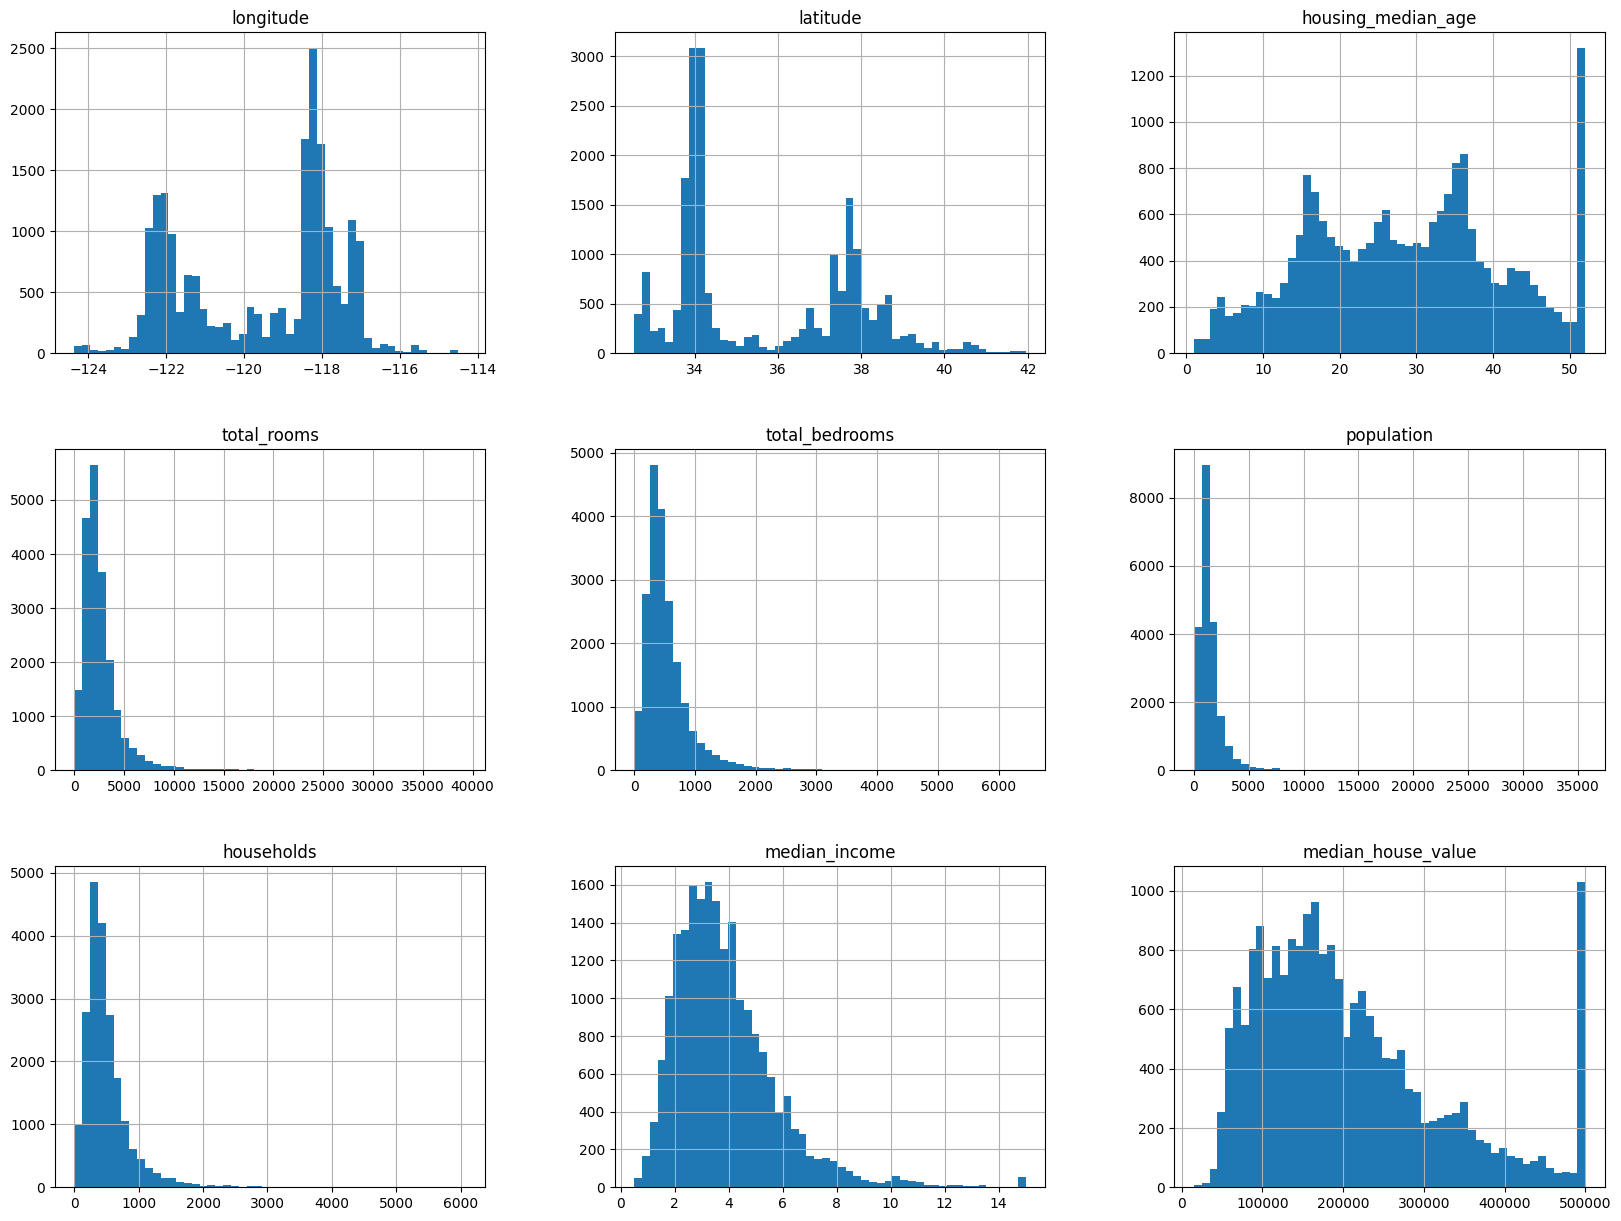

In [6]:
df.hist(bins=50, figsize=(20,15))
plt.show()


variable relationships
Correlation Matrix:
                    longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.10

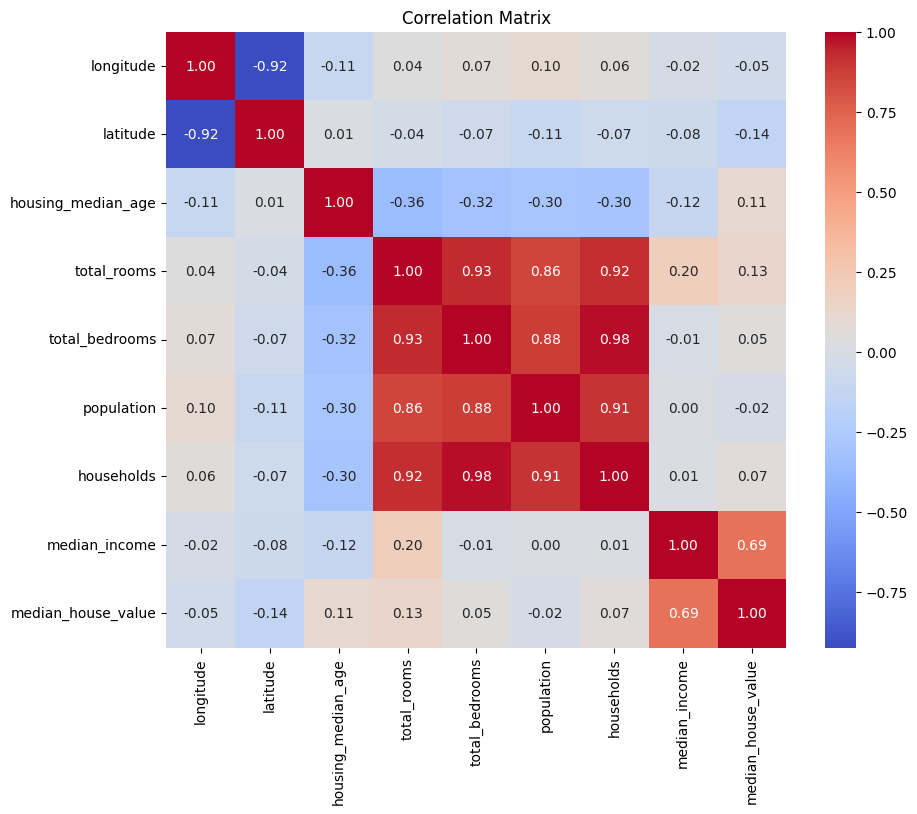

In [7]:
#Variable Relationships
print("variable relationships")
print("Correlation Matrix:")
correlation_matrix = df.select_dtypes(include=['float64']).corr()
print(correlation_matrix)
#Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

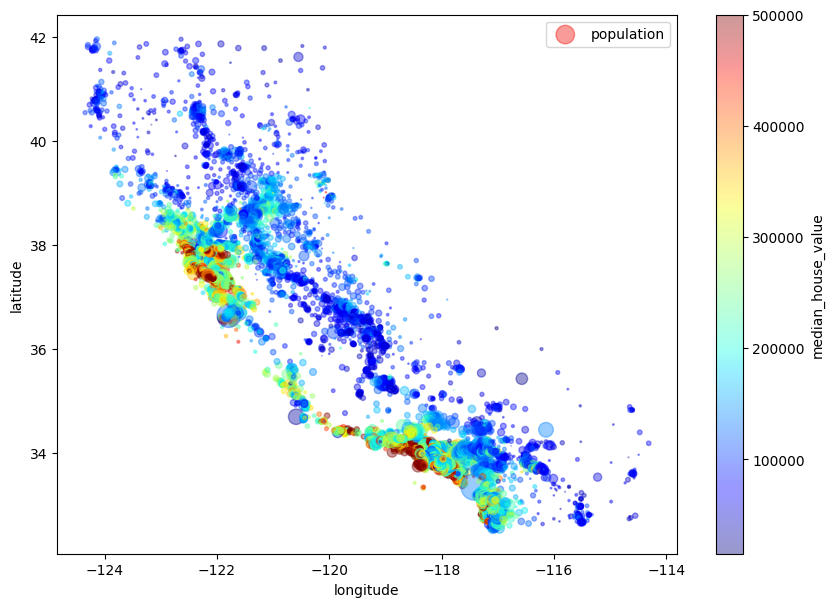

In [8]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df["population"]/100, label="population", figsize=(10,7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.show()


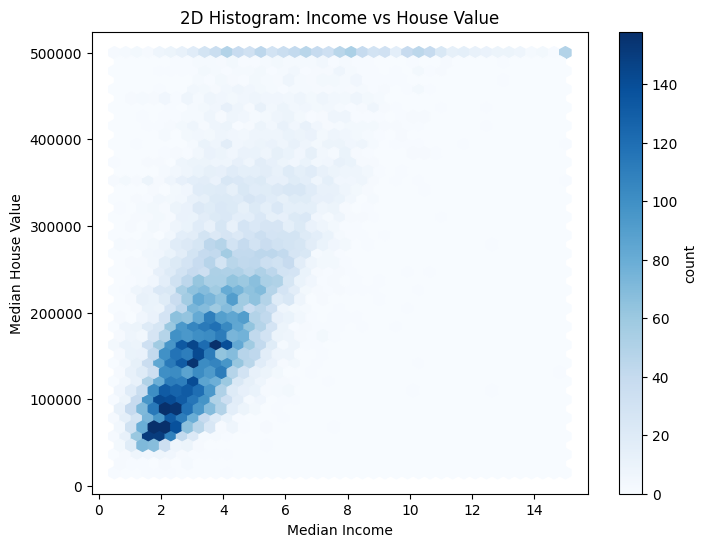

In [9]:
plt.figure(figsize=(8,6))
plt.hexbin(df['median_income'], df['median_house_value'], gridsize=40, cmap="Blues")
plt.colorbar(label="count")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.title("2D Histogram: Income vs House Value")
plt.show()


**EDA ANALYSIS:**

Analysis of the distribution of individual variables revealed that total bedrooms, total rooms, population, and households were all right-skewed. The distribution of latitude and longitude was bimodal, indicating the presence of several densely populated housing clusters, a fact also confirmed by the scatter plot.

I decided to use median_house_value as the target variable and explore its relationship with the remaining variables. Analysis of the correlation matrix revealed that median_income was the most correlated factor. Analysis of the 2D histogram revealed a likely linear relationship between median_house_value and median_income.

# Train and evaluate the model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

In [11]:
# Separate features/target
y = df["median_house_value"].copy()
X = df.drop(columns=["median_house_value"]).copy()

# Identify numeric/categorical columns
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()  # e.g., 'ocean_proximity' in Kaggle data


In [12]:
# 3) Preprocess & model

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ],
    remainder="drop"
)

rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("prep", preprocess),
    ("rf", rf)
])


In [13]:
# 4) Train/test split & fit

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
pipe.fit(X_train, y_train)

# 5) Evaluate performance

def eval_reg(y_true, y_pred, label=""):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)
    try:
        # Newer sklearn (>=0.22) supports squared=False
        rmse = mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older sklearn: no 'squared' kwarg → take sqrt manually
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{label}] R2={r2:.4f} | RMSE={rmse:,.2f} | MAE={mae:,.2f}")
    return {"R2": r2, "RMSE": rmse, "MAE": mae}


y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)
train_scores = eval_reg(y_train, y_tr_pred, "Train")
test_scores  = eval_reg(y_test,  y_te_pred,  "Test")


[Train] R2=0.9763 | RMSE=17,813.46 | MAE=11,522.35
[Test] R2=0.8189 | RMSE=48,712.31 | MAE=31,414.73


In [14]:
# 6) Feature names after preprocessing

def get_feature_names(preprocess, numeric_cols, categorical_cols):
    names = []
    names.extend(numeric_cols)
    if len(categorical_cols) > 0:
        ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
        cat_names = ohe.get_feature_names_out(categorical_cols).tolist()
        names.extend(cat_names)
    return names

feature_names = get_feature_names(pipe.named_steps["prep"], numeric_cols, categorical_cols)



Top features (impurity-based):
                       feature  importance
0                median_income    0.489514
1       ocean_proximity_INLAND    0.141496
2                    longitude    0.106075
3                     latitude    0.101407
4           housing_median_age    0.052442
5                   population    0.032685
6                  total_rooms    0.023817
7               total_bedrooms    0.023658
8                   households    0.017978
9   ocean_proximity_NEAR OCEAN    0.006372
10   ocean_proximity_<1H OCEAN    0.003468
11    ocean_proximity_NEAR BAY    0.000748
12      ocean_proximity_ISLAND    0.000342


<Figure size 800x600 with 0 Axes>

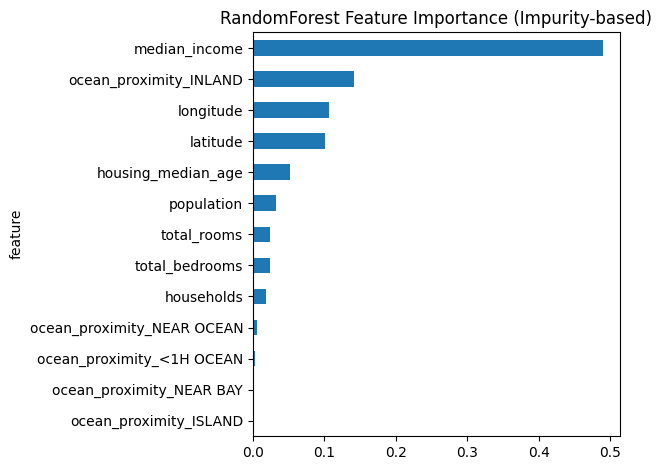

In [15]:
# 7) Impurity-based feature importances

rf_model = pipe.named_steps["rf"]
imp = rf_model.feature_importances_
imp_df = (
    pd.DataFrame({"feature": feature_names, "importance": imp})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)
print("\nTop features (impurity-based):")
print(imp_df.head(15))

# Plot top 15
plt.figure(figsize=(8,6))
imp_df.head(15).iloc[::-1].plot(
    x="feature", y="importance", kind="barh", legend=False
)
plt.title("RandomForest Feature Importance (Impurity-based)")
plt.tight_layout()
plt.show()

**MODEL TRAINING & EVALUATION :**

Using median_house_value as the target variable, I trained a randomforest model and evaluated. The R² indicates good explanation, remaining around 0.82, although slightly lower thaan the test set. However, both the RMSE and MAE errors increased on the test set, suggesting possible overfitting.

The results of the impurity-based feature importance analysis indicate that median_income is the most important influencing feature, or core driver, accounting for nearly half of the total, which is consistent with the EDA analysis. Ocean_proximity_INLAND is the second most important feature. Longitude and latitude are also relatively important, demonstrating the influence of location on housing prices.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay as PDP

# 1) Pick features to visualize (1D PDP)
#    - Use original column names for numeric features (works directly on the pipeline)
# Safe defaults (adjust as you like)
num_features_for_pdp = [
    f for f in ["median_income", "housing_median_age", "latitude", "longitude",
                "population", "households_per_house", "rooms_per_household"]
    if f in X.columns
]


<Figure size 1200x800 with 0 Axes>

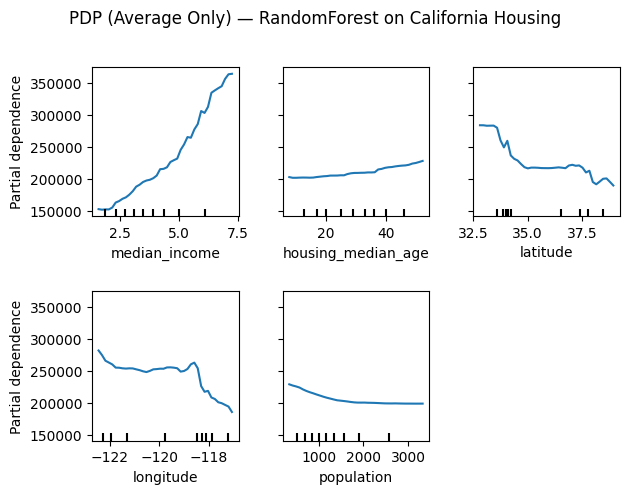

<Figure size 1200x800 with 0 Axes>

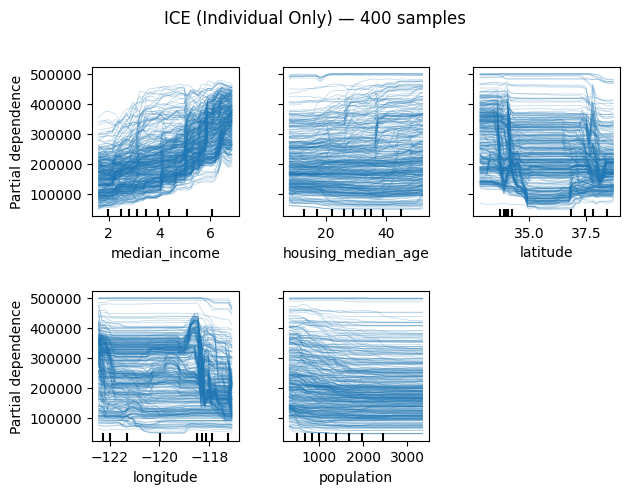

In [22]:
# 2) Make PDP and ICE in separate figures

from sklearn.inspection import PartialDependenceDisplay as PDP

# Choose numeric features you care about (edit as needed)
num_features_for_pdp = [
    f for f in ["median_income", "housing_median_age", "latitude", "longitude",
                "population", "households_per_house", "rooms_per_household"]
    if f in X.columns
]

# (a) PDP — average curves only
fig = plt.figure(figsize=(12, 8))
PDP.from_estimator(
    estimator=pipe,
    X=X_test,                         # raw data; pipeline handles transforms
    features=num_features_for_pdp,    # list of feature names
    kind="average",                   # PDP only
    grid_resolution=40,
    n_jobs=-1
)
plt.suptitle("PDP (Average Only) — RandomForest on California Housing", y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

# (b) ICE — individual curves only (optionally subsample to keep it readable)
N_ICE_SAMPLES = 400  # reduce if too dense; increase if you want more lines
if len(X_test) > N_ICE_SAMPLES:
    X_ice = X_test.sample(N_ICE_SAMPLES, random_state=42)
else:
    X_ice = X_test

fig = plt.figure(figsize=(12, 8))
PDP.from_estimator(
    estimator=pipe,
    X=X_ice,                          # smaller set for ICE readability
    features=num_features_for_pdp,
    kind="individual",                # ICE only
    grid_resolution=40,
    n_jobs=-1
)
plt.suptitle(f"ICE (Individual Only) — {len(X_ice)} samples", y=1.02)
plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


**PDP Plots Analysis:**

From the Partial Dependence Plot, we can see that the median_income curve is clearly upward, indicating that higher income predicts higher housing prices, making it the most intuitive and significant influencing factor. The housing_median_age curve also shows a slight upward trend, but its impact is less pronounced. The latitude and langtitude curves show the impact of geographic location on housing prices, with an overall decreasing trend toward the north and west, but with small peaks in between. The population curve shows that a larger population leads to slightly lower housing prices.

# ALE Plots

In [18]:
def ale_1d(
    model, X: pd.DataFrame, feature: str,
    grid_size: int = 20, subsample: int | None = None, random_state: int = 42
):
    if subsample is not None and len(X) > subsample:
        X_work = X.sample(subsample, random_state=random_state).copy()
    else:
        X_work = X.copy()

    xj = X_work[feature].astype(float).values
    # Guard: must have variation
    if np.allclose(np.min(xj), np.max(xj)):
        raise ValueError(f"Feature {feature} is (near) constant; ALE undefined.")
    # 1) Bin by quantiles (K+1 edges for K bins)
    qs = np.linspace(0, 1, grid_size + 1)
    edges = np.quantile(xj, qs)
    # Ensure strictly increasing edges (jitter if needed)
    edges = np.unique(edges)
    if len(edges) < 2:
        raise ValueError(f"Not enough unique values to bin {feature}.")
    # Recompute grid_size based on unique edges
    K = len(edges) - 1
    # Assign bins in [0..K-1], drop rightmost edge to avoid NaNs at max
    bin_ids = np.clip(np.searchsorted(edges, xj, side="right") - 1, 0, K - 1)

    # 2) Local effects per bin:
    # For each bin k, for rows with xj in [edges[k], edges[k+1]],
    # compute f(x_{j←edges[k+1]}) - f(x_{j←edges[k]}) and then average.
    local_effects = np.zeros(K)
    counts = np.zeros(K, dtype=int)

    for k in range(K):
        mask = bin_ids == k
        if not np.any(mask):
            local_effects[k] = 0.0
            counts[k] = 0
            continue

        X_low = X_work.loc[mask].copy()
        X_high = X_work.loc[mask].copy()

        X_low[feature]  = edges[k]
        X_high[feature] = edges[k + 1]

        # Model handles preprocessing internally (pipeline)
        f_high = model.predict(X_high)
        f_low  = model.predict(X_low)

        diffs = f_high - f_low
        local_effects[k] = np.mean(diffs)
        counts[k] = mask.sum()
    # 3) Accumulate bin-wise averages to get ALE at bin centers
    # ALE at bin 0 is 0 by definition; cumulative sum from 1..K-1
    ale_bins = np.zeros(K)
    ale_bins[1:] = np.cumsum(local_effects[1:])

    # 4) Center the ALE so it integrates to zero over the empirical distribution
    # Weighted centering by bin frequencies
    if counts.sum() > 0:
        ale_centered = ale_bins - np.average(ale_bins, weights=counts)
    else:
        ale_centered = ale_bins

    # Grid centers for plotting
    centers = 0.5 * (edges[:-1] + edges[1:])

    return {
        "grid_centers": centers,
        "ale_values": ale_centered,
        "counts": counts,
        "edges": edges,
        "local_effects": local_effects
    }

def plot_ale_1d(result, feature_name: str, ylabel="ALE", xlabel=None):
    centers = result["grid_centers"]
    ale_vals = result["ale_values"]
    counts   = result["counts"]
    xlabel = xlabel or feature_name

    fig, ax1 = plt.subplots(figsize=(6.5, 4.0))
    ax1.plot(centers, ale_vals, marker="o")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.set_title(f"ALE (1D): {feature_name}")
    ax1.grid(True, alpha=0.3)


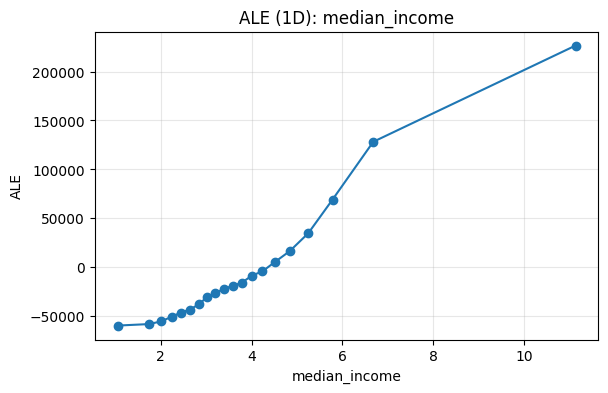

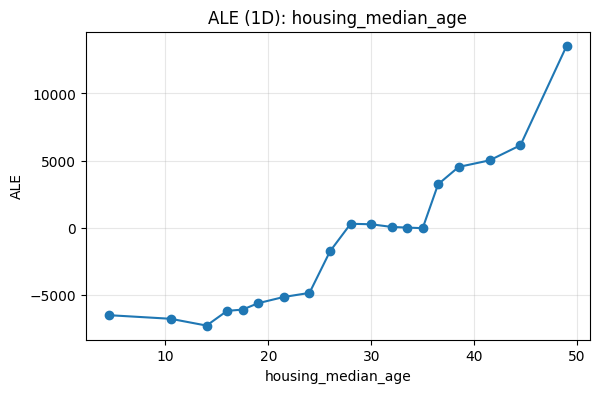

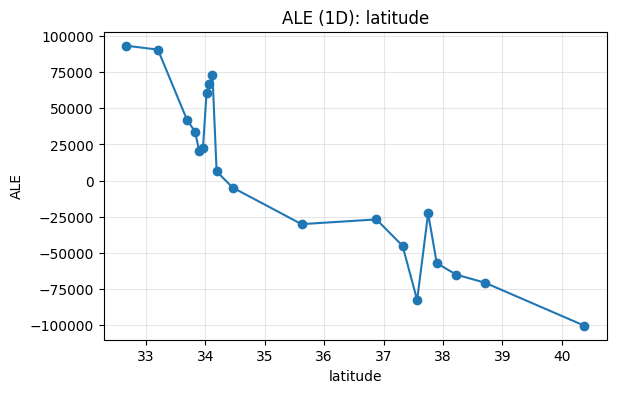

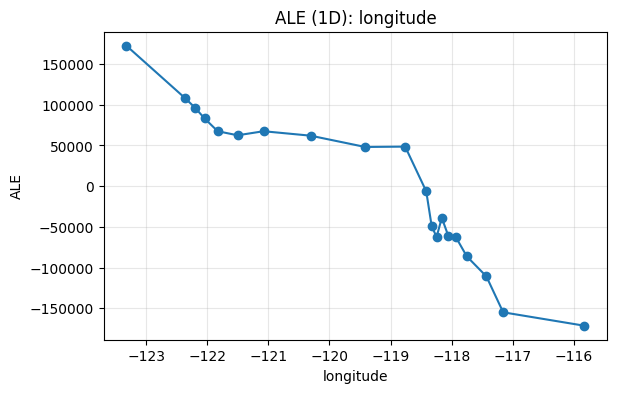

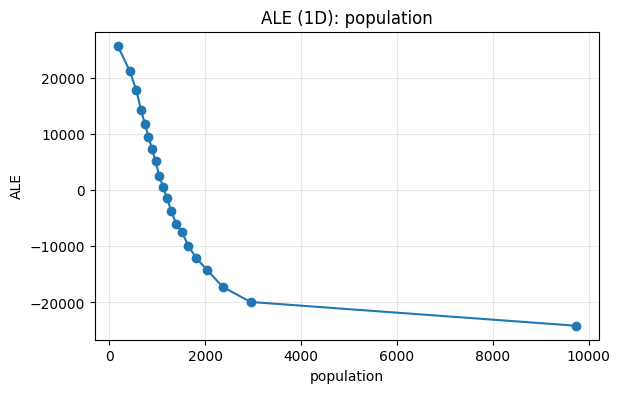

In [19]:
# EXAMPLE USAGE (after you trained `pipe`)
# Choose numeric features you care about
num_features = [
    f for f in ["median_income", "housing_median_age", "latitude", "longitude",
                "population", "households_per_house", "rooms_per_household"]
    if f in X.columns and np.issubdtype(X[f].dtype, np.number)
]

# Compute and plot ALE for a few top features
for feat in num_features[:5]:
    res = ale_1d(model=pipe, X=X_test, feature=feat, grid_size=20, subsample=5000)
    plot_ale_1d(res, feature_name=feat)

**ALE Plots Analysis:**

The curve and conclusions of the ALE plot are similar to those of the PDP. Median_income is still the most important factor and shows a trend close to a linear positive correlation. Housing_median_age rises slowly, while population decreases slowly. The latitude and longitude curves show an overall downward but fluctuating trend.

It's clearer to see that the growth rate is steeper above 6, and above 6.5, a completely straight line form. This may be due to the lack of data above 6.5. Similarly, after the population exceeds 3000, the curve becomes a straight line, which is probably because there is insufficient data in this range.

**Citation:**

The code of  model traning and interpretation plots was generated by ChatGPT on 9.27 at 21:00. The chat link: https://chatgpt.com/share/68d8bed4-7eb4-8008-99d0-9ad9d1079bcc